# Metadata

```
-----------------------------------------
Course:   DS 5001
Module:   12 Lab
Topic:    Classification with Naive Bayes
Author:   R.C. Alvarado
-----------------------------------------
Purpose: We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.
```

# Overview

The prediction of the document's label (class) can be viewed as problem of conditional probability:
* $p(c|d) =$ ?
* $p(c|d) = \large\frac{p(c)p(d|c)}{p(d)}$
* $p(c|d) = p(c)p(d|c)$

We use Maximum A Posteriori estimation (MAP) to predict the label:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)p(d|c)$ 

To solve this, we need to estimate the values of the priors $p(c)$ and the likelihoods $p(d|c)$.
* Prior: $p(c)$ the frequency of a given category.
* Likelihood: $p(d|c)$ the frequency of the document for a given category. Remember, these are essentially unigram language models for each label. They are similar to topics in this sense.

Note that $d$ is a sequence of words $w_{1}^{N}$, which means we apply the independence assumption to avoid the chain rule:
* $p(d|c) = p(w_{1}^{N}|c) = p(w_{1}|c)p(w_{2},w_{1}|c) ... $
* $p(d|c) = \prod{p(w_{i}|c}) = \sum{log(p(w_{i}|c))}$

So, we get:
* $p(c|d) = \underset{C}{\mathrm{argmax}} p(c)\sum{log(p(w_{i}|c))}$ 

We can estimate the priors and the likelihoods using Maximum Likelihood Estimation (MLE) from data that gives the joint distribution of documents and labels, where documents are represented as bags of words. This joint distribution is just the TOKEN table with the label from the LIB table joined to it.
* $(d,w,c)$

**NOTES**
* Both forms of estimation used are optimization methods. 
> **Optimization** is a general term for finding the maximum, or minimum, of some function. **Estimation** is a statistical term for finding some estimate of unknown parameter, given some data. This can be done using optimization methods, e.g. by maximizing the likelihood function, or minimizing a loss function. So optimization is broader, as you can use it without data, just by finding the maximum of some abstract function, while estimation has a clear statistical scope. Optimization can be used for estimation, but you can also use methods not based on optimization for estimation.

# Set Up

In [1]:
data_home = '../data'
local_lib = '../lib'

In [2]:
n_sets = 4 # We want 4 so we can use 3 for training, 1 for testing.
smooth_alpha = 1 
# agg_method = 'sum'
agg_method = 'count'
stopwords = set('and the a of this with is it in to on but an for are has that from not through'.split())

In [3]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import nltk
import matplotlib.pyplot as plt

# Preparation

## Get Data

In [4]:
docs = pd.read_csv(f'{data_home}/winereviews/winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Explore points feature

**Out of curiosity, see if review length correlates with points.**

In [6]:
docs['doc_len'] = docs.doc_content.str.len()

In [7]:
# docs.doc_len.value_counts().sort_index().plot() #hist()

In [8]:
# docs.doc_len.plot.box()

In [9]:
round(docs.points.corr(docs.doc_len), 2)

0.56

<AxesSubplot:>

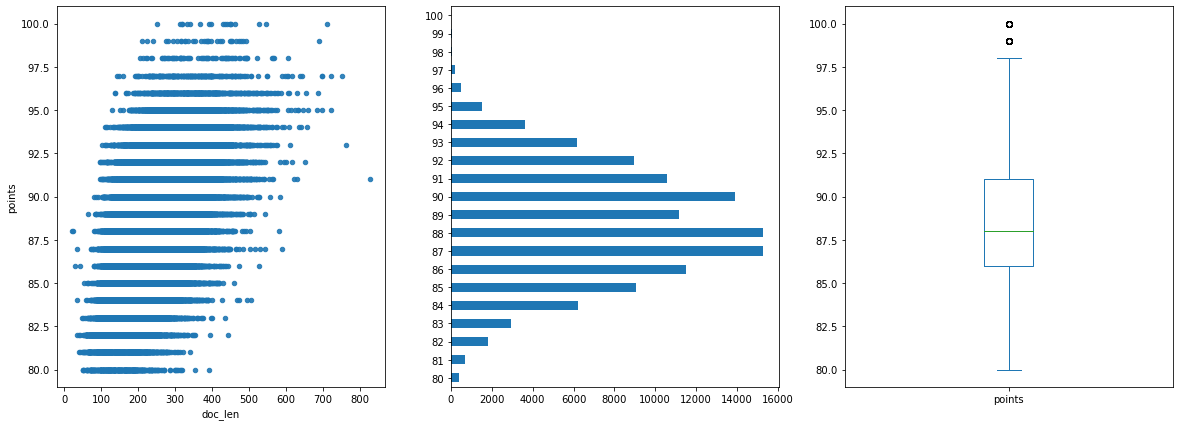

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7), sharey=False)
docs.plot.scatter('doc_len','points', alpha=.9, ax=axes[0]);
docs.points.value_counts().sort_index().plot.barh(rot=0, ax=axes[1]);
docs.points.plot.box(ax=axes[2])

## Convert points to labels

Keep only reviews with high and low ratings. We use $93$ and $87$ by convention.

In [11]:
docs.loc[docs.points >= 93, 'doc_label'] = 'P'
docs.loc[docs.points < 87, 'doc_label'] = 'N'

In [12]:
docs.sample(10)

,doc_content,points,doc_len,doc_label
doc_id,,,,
77967,"Lifted bergamot is the almost singular, striki...",90,178,NaN
9929,"From a top subsection of McLaren Vale, this we...",90,293,NaN
6132,This wine's vividly layered nose blends dusty ...,92,283,NaN
92028,The best bargain Pinot Noir in the state. It's...,85,177,N
30306,"This delicious, fruity wine is full of acidity...",85,145,N
125983,A bit cloudy and still tasting as if it came r...,90,268,NaN
100177,"Full, highly perfumed wine, with peanut and ta...",87,207,NaN
91379,"This affordable, larger-production wine is sof...",88,228,NaN
102279,This aromatic wine does a great job of combini...,90,228,NaN


## Balance Labels

Note the imbalance in number of documents associated with each label.

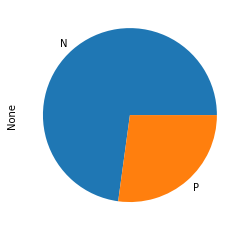

In [13]:
docs.value_counts('doc_label').plot.pie();

In [14]:
CLASS = docs.value_counts('doc_label').to_frame('n')

In [15]:
CLASS

,n
doc_label,
N,32679
P,12184


We use $12000$ as our common value.

In [16]:
DOCS = docs.groupby('doc_label').sample(CLASS.n.min())

In [17]:
DOCS.sample(10)

,doc_content,points,doc_len,doc_label
doc_id,,,,
55298,"Leafy, herbal aromas of plum and raspberry sho...",86,264,N
102827,"Right now, although the nose is closed, exposu...",95,454,P
29538,This blend of Bical and Cercial is toasty and ...,84,131,N
85164,"Fragrant blue flower, woodland berry, underbru...",94,298,P
88469,Light herbal aromas and lively grapefruit flav...,85,153,N
6429,"This is a perfumed wine, dominated by Cabernet...",95,240,P
85699,Dark chocolate and black currant flavors domin...,93,236,P
16455,"A négociant wine, sharp and spicy, with vivid ...",86,277,N
61490,"As with the Indian Wells Cabernet, winemaker B...",85,267,N


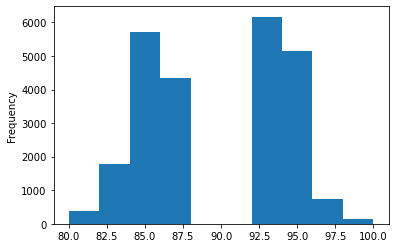

In [18]:
DOCS.points.plot.hist();

**Average `doc_len` per group**

NOTE: Good reviews are few and long, bad reviews are many and short.

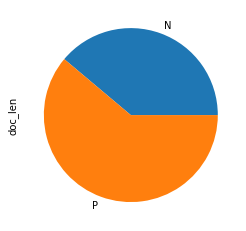

In [19]:
DOCS.groupby('doc_label').doc_len.mean().plot.pie();

## Divide docs into train and test sets

**Assign random numbers to docs**

In [20]:
DOCS['set'] = randint(0, n_sets, len(DOCS.index))

In [21]:
DOCS.head()

,doc_content,points,doc_len,doc_label,set
doc_id,,,,,
118379,"While this wine is dry and crisp with acidity,...",83,186,N,0
37470,"This is a soft wine, with rounded tannins that...",86,194,N,3
69100,"Rubbery and firm on the nose, with generic ber...",85,274,N,0
125065,Milk chocolate and oak aromas blend with light...,86,233,N,3
45873,This is a delicious soft wine with immediate f...,86,198,N,0


**Split docs by assigned number**

In [22]:
DOCS.loc[DOCS.set != 0, 'group'] = 'train'
DOCS.loc[DOCS.set == 0, 'group'] = 'test'

In [23]:
DOCS

,doc_content,points,doc_len,doc_label,set,group
doc_id,,,,,,
118379,"While this wine is dry and crisp with acidity,...",83,186,N,0,test
37470,"This is a soft wine, with rounded tannins that...",86,194,N,3,train
69100,"Rubbery and firm on the nose, with generic ber...",85,274,N,0,test
125065,Milk chocolate and oak aromas blend with light...,86,233,N,3,train
45873,This is a delicious soft wine with immediate f...,86,198,N,0,test
...,...,...,...,...,...,...
11335,Oh the purity of freshly cut red-cheeked apple...,93,330,P,3,train
67010,"Il Sigillo, which translates to “the seal,” op...",93,360,P,0,test
15454,"Aromas recall mature dark berry, stewed plum, ...",93,253,P,2,train


In [24]:
round(DOCS.value_counts('group')[0] / DOCS.value_counts('group')[1], 2)

2.98

## Convert docs to tokens

In [25]:
def tokenize_docs(doc_df):

    # Parse sentences with NLTK
    sent_df = doc_df.doc_content.apply(lambda x: pd.Series(nltk.sent_tokenize(x))).stack().to_frame('sent_str')
    sent_df.index.names = ['doc_id', 'sent_num']
    
    # Get tokens with POS with NLTK
    token_df = sent_df.sent_str.apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))
    token_df = token_df.stack().to_frame('pos_tuple')
    
    # Extract features
    token_df['pos'] = token_df.pos_tuple.apply(lambda x: x[1])
    token_df['token_str'] = token_df.pos_tuple.apply(lambda x: x[0])
    token_df['term_str'] = token_df.token_str.str.lower()
    
    # Remove unwanted terms
    token_df = token_df[token_df.term_str.str.match(r'^[a-z0-9]+$')]
    token_df = token_df.loc[~token_df.term_str.isin(stopwords)]
    
    # Fix columns and index
    token_df = token_df.drop('pos_tuple', axis=1)
    token_df.index.names = ['doc_id','sent_num','token_num']
    
    return token_df

In [26]:
TOKENS = tokenize_docs(DOCS)
TOKENS = TOKENS.sort_index()

In [27]:
TOKENS

pos token_str term_str
doc_id sent_num token_num                        
31     0        0          NNP    Merlot   merlot
                2          NNP      Nero     nero
                4           VB      form     form
                6           NN      base     base
                9           JJ      easy     easy
...                        ...       ...      ...
129851 1        8           VB    tomato   tomato
                9           NN     pasta    pasta
                10          NN     sauce    sauce
                11          CC        or       or
                12          NN     pizza    pizza

[679367 rows x 3 columns]

## Extract VOCAB

**Note that we only use the vocabulary of the training data.**

In [28]:
train_doc_idx = DOCS.loc[DOCS.group == 'train'].index
test_doc_idx = DOCS.loc[DOCS.group == 'test'].index

In [29]:
VOCAB = TOKENS.loc[train_doc_idx].term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['df'] = TOKENS.loc[train_doc_idx].value_counts(['doc_id','term_str']).groupby('term_str').count()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(train_doc_idx)/VOCAB.df)

In [30]:
VOCAB.sort_values('dfidf', ascending=False).head(10)

,n,df,dfidf
term_str,,,
fruit,6136,5539,9527.306590
flavors,8635,8240,9451.462180
palate,5134,4975,9327.975357
aromas,4892,4828,9261.266440
acidity,4862,4753,9224.755698
drink,4668,4612,9151.471382
finish,4537,4505,9091.717729
wine,12138,9468,8962.472620
tannins,4409,4278,8952.698787


# Convert to BOW

In [31]:
BOW = TOKENS.groupby(['doc_id','term_str']).term_str.count().to_frame('n')

In [32]:
BOW

n
doc_id term_str     
31     base        1
       bright      1
       clean       1
       easy        1
       fettuccine  1
...               ..
129851 sauce       1
       sicily      1
       tomato      1
       wine        1
       would       1

[657946 rows x 1 columns]

CPU times: user 284 ms, sys: 72 ms, total: 356 ms
Wall time: 355 ms


<AxesSubplot:>

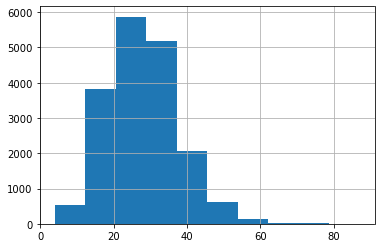

In [33]:
%time BOW.loc[train_doc_idx].groupby('doc_id').n.sum().hist();

## Transfer doc labels and splits to tokens &rarr; CRUCIAL

In [34]:
BOW = BOW.join(DOCS.doc_label)

In [35]:
BOW.sample(10)

,,n,doc_label
doc_id,term_str,,
52577,bring,1,N
32561,acidity,1,N
4510,its,2,P
98616,like,1,N
41415,floor,1,P
35834,perfumes,1,P
39313,time,1,P
9400,ascent,1,P
125782,palate,1,P


In [36]:
BOW.doc_label.value_counts()

P    400176
N    257770
Name: doc_label, dtype: int64

# Training

## Estimate priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [37]:
Nc = BOW.loc[train_doc_idx].groupby(['doc_label']).n.agg(agg_method)
Nd = BOW.loc[train_doc_idx].n.agg(agg_method)
class_priors = Nc / Nd

In [38]:
np.round(class_priors, 2)

doc_label
N    0.39
P    0.61
Name: n, dtype: float64

**Convert priors to logs**

In [39]:
class_priors_log = log(class_priors)

In [40]:
class_priors_log

doc_label
N   -1.362365
P   -0.710624
Name: n, dtype: float64

## Estimate likelihoods $p(w|c)$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [41]:
class_likelihoods = BOW.loc[train_doc_idx].groupby(['term_str', 'doc_label']).n.agg(agg_method).unstack().fillna(0)

In [42]:
class_likelihoods.sample(10).style.background_gradient(cmap='GnBu', axis=None)

doc_label,N,P
term_str,,
miracles,2.000000,0.000000
gracing,0.000000,2.000000
spun,5.000000,0.000000
vidal,7.000000,0.000000
expand,4.000000,15.000000
judging,3.000000,2.000000
pales,1.000000,0.000000
pentratingly,0.000000,1.000000
granddaughter,0.000000,1.000000


In [43]:
class_likelihoods = class_likelihoods + smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [44]:
class_likelihoods.sample(10).style.background_gradient(cmap='GnBu', axis=None)

doc_label,N,P
term_str,,
bucks,0.000034,0.000006
mars,0.000039,0.000003
tavakoli,0.000005,0.000006
cellars,0.000010,0.000044
at,0.002832,0.003859
intrusively,0.000010,0.000003
sudsy,0.000014,0.000003
heaping,0.000014,0.000006
absberg,0.000005,0.000006


## Convert likelihoods to logs

In [45]:
class_likelihoods_log = np.log(class_likelihoods)

In [46]:
class_likelihoods_log.sample(10).style.background_gradient(cmap='GnBu', axis=None)

doc_label,N,P
term_str,,
found,-8.981962,-9.620202
spicy,-6.297259,-6.476460
swaying,-12.240059,-11.971577
southwest,-10.294148,-12.664725
helpful,-11.546911,-12.664725
pod,-12.240059,-11.278430
candle,-10.853764,-10.467500
pumping,-11.546911,-11.971577
beach,-10.160617,-11.566112


# Testing

## Add likelihood columns to test tokens table

This is effectively how we apply our model to the test set.

In [47]:
TEST = BOW.loc[test_doc_idx].join(class_likelihoods_log[['P','N']], on='term_str', how='inner').sort_index() # Inner join removes unfound terms

In [48]:
TEST

n doc_label          P          N
doc_id term_str                                      
34     acidity      1         N  -4.818526  -4.544301
       blanc        1         N  -8.445217  -6.806337
       commendable  1         N -11.971577 -11.141446
       dryness      1         N  -8.347236  -8.774323
       flavor       1         N  -6.568900  -6.171633
...                ..       ...        ...        ...
129847 rich         1         N  -5.059830  -6.171633
       smoky        1         N  -6.501410  -6.801979
       soft         1         N  -6.281218  -5.095651
       swamps       1         N -11.971577 -12.240059
       violets      1         N  -7.820538  -9.195536

[163193 rows x 4 columns]

## Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$

In [79]:
%%time
DOCS.loc[test_doc_idx, 'prediction'] = TEST.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum())\
    .apply(lambda x: x + class_priors_log, 1)\
    .idxmax(1)

CPU times: user 6.96 s, sys: 1.01 s, total: 7.96 s
Wall time: 9.54 s


In [50]:
DOCS.loc[test_doc_idx].sample(10)

,doc_content,points,doc_len,doc_label,set,group,prediction
doc_id,,,,,,,
64280,"This wine seems sweet, with apricot, orange, l...",84,118,N,0,test,N
128378,"Clear in color and texture, this is a refined ...",93,416,P,0,test,P
39455,The 2008 Cornas from Colombo have turned out v...,93,299,P,0,test,P
42123,"Light, lean and easy to drink, this ruby red o...",84,261,N,0,test,N
104717,"This is light, fruity and spicy, with a crisp ...",86,114,N,0,test,N
5544,"Dark and ominous in color, with a grapy, rusti...",82,187,N,0,test,N
17739,An awesome wine that shows the power of the es...,94,340,P,0,test,P
113876,This is not a declared vintage but one that ha...,93,337,P,0,test,P
98395,Strikingly golden in color this tightly holds ...,95,372,P,0,test,P


# Evaluation

In [51]:
DOCS.loc[test_doc_idx, 'result'] = DOCS.loc[test_doc_idx].doc_label == DOCS.loc[test_doc_idx].prediction
DOCS.loc[test_doc_idx, 'result_type'] = DOCS.loc[test_doc_idx].apply(lambda x: str(x.result)[0] + x.prediction, 1)

In [52]:
DOCS.loc[test_doc_idx].sample(10)

,doc_content,points,doc_len,doc_label,set,group,prediction,result,result_type
doc_id,,,,,,,,,
104638,"Here's a slender but aromatic red, with a plea...",86,133,N,0,test,P,False,FP
57815,"A blend of various vineyards, this is a seamle...",93,261,P,0,test,P,True,TP
108465,"This is a new, low-production designation, a s...",94,361,P,0,test,P,True,TP
6280,The trick with getting a Chardonnay this honey...,94,419,P,0,test,P,True,TP
19242,"Rich, oaky and earthy, with char to the bouque...",86,253,N,0,test,N,True,TN
57870,"Tight at first, this elegant Pinot from cooler...",93,242,P,0,test,P,True,TP
99926,Apple and cinnamon aromas on the nose provide ...,84,210,N,0,test,N,True,TN
1462,"Aromas of forest floor, baked plum, clove and ...",93,231,P,0,test,P,True,TP
29957,"This wine is concentrated, deep and tannic, ye...",93,264,P,0,test,P,True,TP


## Show raw T & F counts

In [53]:
raw = DOCS.loc[test_doc_idx].result.value_counts()

In [54]:
raw

True     5743
False     377
Name: result, dtype: int64

## Show raw TP, TN, FP, FN counts

In [55]:
raw1 = DOCS.loc[test_doc_idx].result_type.value_counts()

In [56]:
raw1

TP    2937
TN    2806
FP     304
FN      73
Name: result_type, dtype: int64

In [57]:
# Accuracy
(raw1.TP + raw1.TN) / raw1.sum()

0.9383986928104575

## Create confusion matrix

In [58]:
CM = DOCS.loc[test_doc_idx].reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [59]:
CM.columns.name = 'actual'

In [60]:
CM

actual,N,P
prediction,,
N,2806,73
P,304,2937


In [61]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        
        ACC = T / ALL                       # Accuracy
        TPR = TP / (TP + FN)                # Recall, Sensitivity
        TNR = TN / (TN + FP)                # Specificity
        PPV = TP / (TP + FP)                # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2                # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [62]:
R = get_results(CM)

In [63]:
R.show_results()

TPR: 0.9 (sensitivity)
TNR: 0.98 (specificity)
F1:  0.94 <-- GRADE
---------
PPV: 0.97 (precision)
ACC: 0.94 (accuracy)


# Exploration

## Likelihoods as Sentiment Lexicon 

Remember, the likelihoods are language models.

**We make up a way to compute sentiment valence and polarity**

In [64]:
SALEX = (np.sign(class_likelihoods['P'] - class_likelihoods['N'])).to_frame('polarity')
SALEX['valence'] = (class_likelihoods['P'] - class_likelihoods['N'])

In [65]:
SALEX

,polarity,valence
term_str,,
1,1.0,0.000012
10,1.0,0.000298
100,1.0,0.000368
100ml,-1.0,-0.000007
100th,1.0,0.000001
...,...,...
zone,1.0,0.000008
zonin,-1.0,-0.000007
zotovich,1.0,0.000001


**Ratio of positive to negative terms**

This may be a function of doc_length.

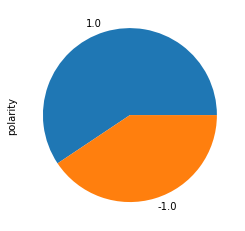

In [66]:
SALEX.polarity.value_counts().plot(kind='pie');

## Compare Positive to Negative Words

### Top positives

In [67]:
SALEX.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
rich,1.0,0.004259
black,1.0,0.004237
years,1.0,0.003830
concentrated,1.0,0.002809
dark,1.0,0.002797
complex,1.0,0.002535
vineyard,1.0,0.002467
age,1.0,0.002397
tannins,1.0,0.002369


### Top negatives

In [68]:
SALEX.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-0.012111
aromas,-1.0,-0.006948
finish,-1.0,-0.006418
soft,-1.0,-0.004252
light,-1.0,-0.003905
simple,-1.0,-0.003895
fruity,-1.0,-0.003465
crisp,-1.0,-0.003048
green,-1.0,-0.002918


### Bar Chart

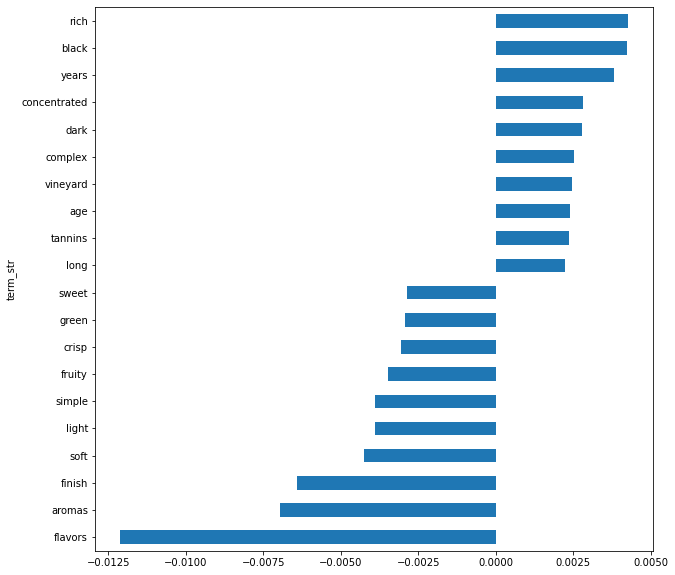

In [69]:
wpos = SALEX.valence.sort_values(ascending=False).head(10)
wneg = SALEX.valence.sort_values(ascending=False).tail(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(10,10));

# Save

In [70]:
DOCS.to_csv(f"{data_home}/winereviews/winereviews-DOCS.csv", index=True)
BOW.to_csv(f"{data_home}/winereviews/winereviews-BOW.csv", index=True)
VOCAB.to_csv(f"{data_home}/winereviews/winereviews-VOCAB.csv", index=True)
SALEX.to_csv(f"{data_home}/winereviews/winereviews-NB_SALEX.csv", index=True)

# Appendix: Convert Points to Grades

You might do this if you wanted a multinomial model that distinguished betwen A+, A, A-, et.c

In [71]:
def convert_num_to_grade(num:int):
    letter = ''

    if num < 90:
        letter = 'B'
    else:
        letter = 'A'
        
    if num % 10 < 3:
        # letter += '-'
        letter += '0'
    elif num % 10 > 6:
        # letter += '+'
        letter += '2'
    else:
        # letter += ''
        letter += '1'
        
    return letter

In [72]:
def test_convert_num_to_grade():
    for num in range(80,101):
        let = convert_num_to_grade(num)
        print(num, let)

In [73]:
test_convert_num_to_grade()

80 B0
81 B0
82 B0
83 B1
84 B1
85 B1
86 B1
87 B2
88 B2
89 B2
90 A0
91 A0
92 A0
93 A1
94 A1
95 A1
96 A1
97 A2
98 A2
99 A2
100 A0


In [74]:
docs['grade'] = docs.points.apply(convert_num_to_grade)

In [75]:
docs

,doc_content,points,doc_len,doc_label,grade
doc_id,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,172,NaN,B2
1,"This is ripe and fruity, a wine that is smooth...",87,227,NaN,B2
2,"Tart and snappy, the flavors of lime flesh and...",87,186,NaN,B2
3,"Pineapple rind, lemon pith and orange blossom ...",87,199,NaN,B2
4,"Much like the regular bottling from 2012, this...",87,249,NaN,B2
...,...,...,...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,227,NaN,A0
129967,Citation is given as much as a decade of bottl...,90,233,NaN,A0
129968,Well-drained gravel soil gives this wine its c...,90,225,NaN,A0


## Expected Mutual Information

![](emi.png)

In [76]:
training_tokens.head()

NameError: name 'training_tokens' is not defined

In [ ]:
p_c = class_priors.to_frame()
p_c.columns = ['p']
p_c.index.name = 'doc_label'

In [ ]:
p_c

In [ ]:
p_w = (training_tokens.term_str.value_counts() / training_tokens.shape[0]).to_frame()
p_w.columns = ['p']
# p_w.index.name = 'term_id'
# p_w['term_str'] = vocab.term_str

In [ ]:
p_w.sort_values('p', ascending=False).head()

In [ ]:
p_cw = training_tokens.groupby(['term_str','doc_label']).count() / training_tokens.shape[0]
p_cw.columns = ['p']

In [ ]:
p_cw.head()

In [ ]:
EMI = training_tokens.join(p_cw, on=['term_str','doc_label'], how='left').rename(columns={'p':'p_cw'})
EMI = EMI.join(p_w['p'], on='term_str', how='left').rename(columns={'p':'p_w'})
EMI = EMI.join(p_c, on='doc_label', how='left').rename(columns={'p':'p_c'})
EMI['emi'] = EMI.p_cw * log(EMI.p_cw/(EMI.p_c * EMI.p_w))
EMI = EMI[['doc_label','term_str','emi']].drop_duplicates().set_index(['doc_label','term_str'])

In [ ]:
EMIX = EMI.unstack(fill_value=0).T
EMIX.index = EMIX.index.droplevel(0)

In [ ]:
EMIX.sort_values('P', ascending=False)#.head(100)

In [ ]:
EMIX.sort_values('N', ascending=False)#.head(100)

In [ ]:
EMIX.to_csv(f'{data_out}/{prefix}-EMI_SALEX.csv', index=True)